# Navigation from pixels
---

In this notebook, the navigation project is presented. 

The proposed problem is based on getting an agent to learn to determine which bananas are good and which bad.
For this we have a 84x84 rgb image (state), our task will be to find a function that maps the state in the best possible action.

To carry out this mapping, it is proposed to use a pretrained mobilenet_v2 (with imagenet).

All the code to facilitate the organization is in the **code** folder. Where we found:
* **agent.py**: The proposed agent to solve the navigation problem.
* **config.py**: Configuration of the hyperparameters of the learning process.
* **models.py**: The proposed neural networks architectures.

In [1]:
# Much faster than opencv imread
!pip install lycon

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.


### Project dependences

In [1]:
# Import all dependences
import os
import glob
import torch
import lycon
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# Unity env
from unityagents import UnityEnvironment

# Project dependences
from code.config import Config
Config.BATCH_SIZE = 256
from code.agent import Agent
from code.model import PixelBananasNet

### Init the Unity environment

In [2]:
# Get the unity environment
env = UnityEnvironment(file_name=Config.BANANA_PIXELS_ENV_PATH)

# Select the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Display information about the problem:

Number of agents: 1
Number of actions: 4
States look like:


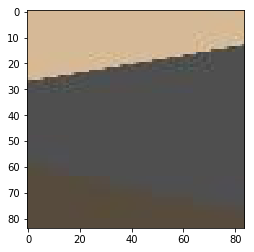

States have shape: (1, 84, 84, 3)


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.visual_observations[0]
print('States look like:')
plt.imshow(np.squeeze(state))
plt.show()
state_size = state.shape
print('States have shape:', state.shape)

### Init the Agent
The proposed agent is prepared to allow as input a pretrained mobilenet_v2 architecture.

The network proposed for this exercise is called **PixelBananasNet**, also with funny name but MORE powerful than the previour BananasNet it will allow us to navigate autonomously using rgb 84x84 camera through the scene and get our precious high resolution bananas! Mmmmm ...

In [4]:
agent = Agent(PixelBananasNet, state_size[1], action_size, alpha=.5)

# Some problems produces learning crashes
#last_weights_path = sorted(glob.glob(os.path.join(Config.CHECKPOINT_PIXELS_BANANA_PATH, "*.pth")), key=lambda f: os.path.getmtime(f), reverse=True)[0]
#agent.load(last_weights_path)

### Main loop
In order to monitoring the learning proces, the following function controls the workflow of the agent.

In [5]:
def normalize(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    return np.stack(((image[..., 0] - mean[0]) / std[0],
                     (image[..., 1] - mean[1]) / std[1],
                     (image[..., 2] - mean[2]) / std[2]), axis=-1)

In [6]:
def dqn(n_episodes=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = normalize(lycon.resize(env_info.visual_observations[0][0], 
                             height=96, 
                             width=96, 
                             interpolation=lycon.Interpolation.NEAREST).astype(np.float32)).transpose(2, 0, 1)
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = normalize(lycon.resize(env_info.visual_observations[0][0], 
                                      height=96, 
                                      width=96, 
                                      interpolation=lycon.Interpolation.NEAREST).astype(np.float32)).transpose(2, 0, 1)
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, 
                       np.array([action]), 
                       np.array([reward]), 
                       next_state, 
                       np.array([done]))
            state = next_state
            score += reward
            if done:
                break 
        
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            agent.save(os.path.join(Config.CHECKPOINT_PIXELS_BANANA_PATH, 'checkpoint_%d.pth') % (i_episode, ))
            
    return scores

In [ ]:
# ¡Execute please! ¡I want bananas!
scores = dqn()

Episode 100	Average Score: 0.28
Episode 200	Average Score: 0.06
Episode 300	Average Score: 0.14
Episode 400	Average Score: 0.29
Episode 500	Average Score: 0.76
Episode 600	Average Score: 0.88
Episode 700	Average Score: 0.88
Episode 800	Average Score: 1.17
Episode 900	Average Score: 1.52
Episode 1000	Average Score: 2.36
Episode 1100	Average Score: 2.82
Episode 1200	Average Score: 3.03
Episode 1300	Average Score: 3.66
Episode 1400	Average Score: 4.72
Episode 1500	Average Score: 4.37
Episode 1600	Average Score: 4.62
Episode 1700	Average Score: 4.91
Episode 1800	Average Score: 5.43
Episode 1900	Average Score: 5.12
Episode 2000	Average Score: 5.37
Episode 2014	Average Score: 5.59

### Plot learning curve

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Play with the last checkpoint
![Banana image](doc/banana.jpg)

In [ ]:
model_path = sorted(glob.glob(os.path.join(Config.MODEL_PIXELS_BANANA_PATH, "*.pth")), key=lambda f: os.path.getmtime(f), reverse=True)[0]
#last_weights_path = sorted(glob.glob(os.path.join(Config.CHECKPOINT_PIXELS_BANANA_PATH, "*.pth")), key=lambda f: os.path.getmtime(f), reverse=True)[0]
agent.load(model_path)

env_info = env.reset(train_mode=False)[brain_name]
state = normalize(lycon.resize(env_info.visual_observations[0][0], 
                     height=96, 
                     width=96, 
                     interpolation=lycon.Interpolation.NEAREST).astype(np.float32)).transpose(2, 0, 1)
score = 0
while True:
    action = agent.act(state, eps)
    env_info = env.step(action)[brain_name]
    next_state = normalize(lycon.resize(env_info.visual_observations[0][0], 
                              height=96, 
                              width=96, 
                              interpolation=lycon.Interpolation.NEAREST).astype(np.float32)).transpose(2, 0, 1)
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    score += reward
    state = next_state
    if done:
        break
    
print("Score: {}".format(score))